In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation,
                                     RandomContrast, Resizing, Rescaling)
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import  SparseCategoricalAccuracy, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import L2
from tensorflow.train import BytesList, FloatList, Int64List, Example, Features, Feature
import sklearn
import tensorflow_probability as tfp
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
TRAIN_DIRECTORY =  "C:/Datasets/fer2013/train"
VAL_DIRECTORY = "C:/Datasets/fer2013/test"
CLASS_NAMES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

CONFUGURATIONS = {
    'BATCH_SIZE' : 32,
    'IM_SIZE' : 256,
    'LEARNING_RATE' : 0.001,
    'EPOCHS' : 5,
    'DROPOUT_RATE' : 0.0,
    'REGULARIZATION_RATE' : 0.0,
    'N_FILTERS' : 6,
    'KERNAL_SIZE' : 3,
    'N_STRIDES' : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 100,
    "N_DENSE_2": 10,
    'NUM_CLASSES': 7
}

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    labels='inferred', ## consider file as class
    label_mode='categorical', ## factorized classes
    class_names=CLASS_NAMES, ## Defined class name as per subdirectories
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=22
)

Found 28709 files belonging to 7 classes.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    VAL_DIRECTORY,
    labels='inferred', ## consider file as class
    label_mode='categorical', ## factorized classes
    class_names=CLASS_NAMES, ## Defined class name as per subdirectories
    color_mode='rgb',
    batch_size=CONFUGURATIONS['BATCH_SIZE'],
    image_size=(CONFUGURATIONS['IM_SIZE'], CONFUGURATIONS['IM_SIZE']),
    shuffle=True,
    seed=22
)

Found 7178 files belonging to 7 classes.


In [7]:
for image in train_data.take(1):
    print(image)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[146., 146., 146.],
         [146., 146., 146.],
         [146., 146., 146.],
         ...,
         [166., 166., 166.],
         [166., 166., 166.],
         [166., 166., 166.]],

        [[146., 146., 146.],
         [146., 146., 146.],
         [146., 146., 146.],
         ...,
         [166., 166., 166.],
         [166., 166., 166.],
         [166., 166., 166.]],

        [[146., 146., 146.],
         [146., 146., 146.],
         [146., 146., 146.],
         ...,
         [166., 166., 166.],
         [166., 166., 166.],
         [166., 166., 166.]],

        ...,

        [[ 24.,  24.,  24.],
         [ 24.,  24.,  24.],
         [ 24.,  24.,  24.],
         ...,
         [159., 159., 159.],
         [159., 159., 159.],
         [159., 159., 159.]],

        [[ 24.,  24.,  24.],
         [ 24.,  24.,  24.],
         [ 24.,  24.,  24.],
         ...,
         [159., 159., 159.],
         [159., 159., 159.],
       

#### **DATA VISUALIZATION**

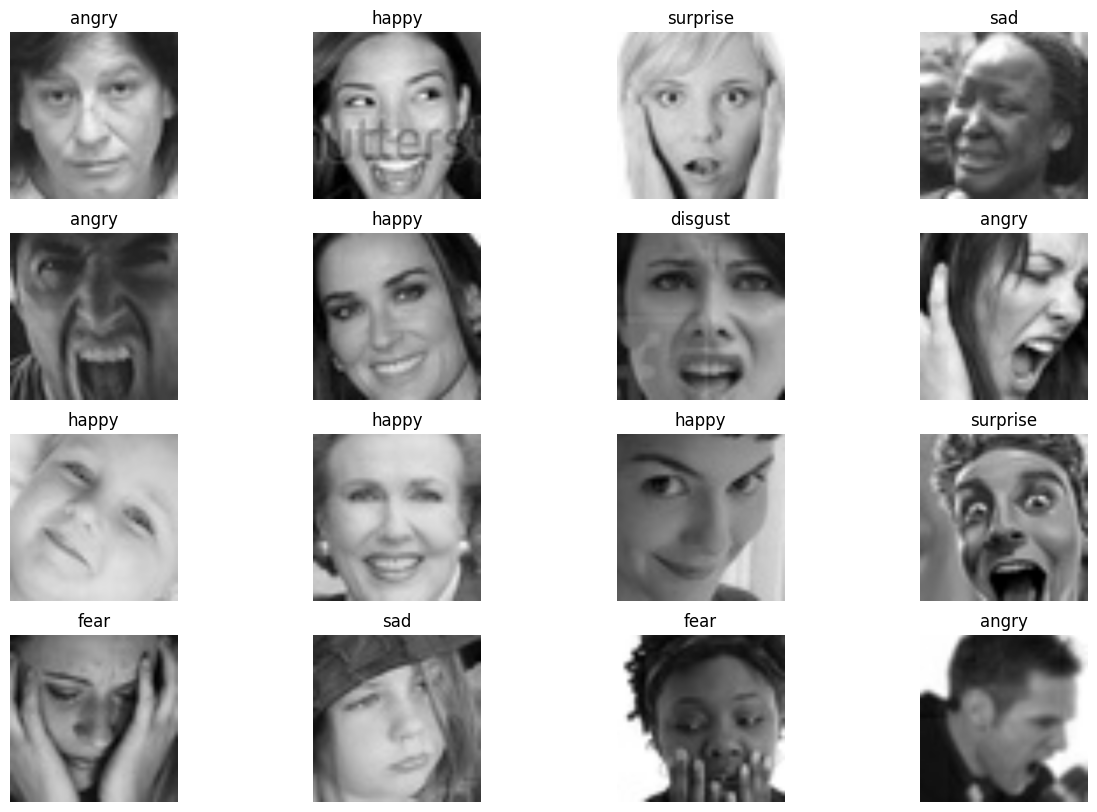

In [8]:
plt.figure(figsize=(15,10))
for images,labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis = 0).numpy()])
        plt.axis("off")

#### **DATASET AUGMENTATION**

In [9]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1)
])

In [10]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

#### **CUTMIX AUGUMENTATION**

In [10]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFUGURATIONS["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFUGURATIONS["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFUGURATIONS["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFUGURATIONS["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFUGURATIONS["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFUGURATIONS["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFUGURATIONS["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFUGURATIONS["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [11]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFUGURATIONS["IM_SIZE"], CONFUGURATIONS["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFUGURATIONS["IM_SIZE"], CONFUGURATIONS["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFUGURATIONS["IM_SIZE"]*CONFUGURATIONS["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

#### **DATASET PREPARATION**

In [11]:
train_dataset_1 = train_data.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_data.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [12]:
train_data = (
    train_data.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)#.prefetch(tf.data.AUTOTUNE)
)

In [13]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [14]:
# train_data = (
#     mixed_dataset.map(cutmix, 
#                       num_parallel_calls=tf.data.AUTOTUNE)#.prefetch(tf.data.AUTOTUNE)
# )

In [15]:
# val_data = (
#     val_data.prefetch(tf.data.AUTOTUNE)
# )

In [16]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFUGURATIONS['IM_SIZE'], CONFUGURATIONS['IM_SIZE']),
    Rescaling(1./255)
])

#### **TF RECORDS**

In [14]:
## Unbaching the training data for creating tensorflow records
train_data = (
    train_data.unbatch()
)

In [15]:
## Unbaching the validation data for creating tensorflow records
# val_data = (
#     val_data.unbatch()
# )

In [16]:
train_data

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

In [17]:
## Serializing the image as bytes feature
def create_example(image, label):

    bytes_feature = Feature(
        bytes_list=BytesList(value=[image]))

    int_feature = Feature(
        int64_list=Int64List(value=[label]))

    example = tf.train.Example(
        features=Features(feature={
            'images': bytes_feature,
            'labels': int_feature,
        }))
    
    return example.SerializeToString()

In [18]:
## Number of shards and tfrecord path
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [19]:
## Encoding the image as byte
def image_to_byte_encoder(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, tf.argmax(label)

In [20]:
## Encoding training images into bytes
encoded_data = (
    train_data.map(image_to_byte_encoder)
)

In [ ]:
## Creating tf records for the training data
for shard_number in range(NUM_SHARDS):
    sharded_data = (
        encoded_data.shard(NUM_SHARDS, shard_number).as_numpy_iterator()
    )

    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in sharded_data:
            example = create_example(encoded_image, encoded_label)
            file_writer.write(example)

In [232]:
## Recostructing the dataset
recons_data = tf.data.TFRecordDataset(filenames= [PATH.format(p)  for p in range(NUM_SHARDS-2)])

In [233]:
def parse_tfrecords(example):

    feature_description = {
        "images" : tf.io.FixedLenFeature([], tf.string),
        "labels" : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [234]:
parsed_data = (
    recons_data.map(parse_tfrecords).batch(CONFUGURATIONS["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)
)

In [240]:
parsed_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [235]:
for i in parsed_data.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.63529414, 0.63529414, 0.63529414],
         [0.50980395, 0.50980395, 0.50980395],
         [0.27058825, 0.27058825, 0.27058825],
         ...,
         [0.6862745 , 0.6862745 , 0.6862745 ],
         [0.27058825, 0.27058825, 0.27058825],
         [0.8705883 , 0.8705883 , 0.8705883 ]],

        [[0.3137255 , 0.3137255 , 0.3137255 ],
         [0.14117648, 0.14117648, 0.14117648],
         [0.854902  , 0.854902  , 0.854902  ],
         ...,
         [0.9686275 , 0.9686275 , 0.9686275 ],
         [0.6745098 , 0.6745098 , 0.6745098 ],
         [0.3921569 , 0.3921569 , 0.3921569 ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.7686275 , 0.7686275 , 0.7686275 ],
         [0.427451  , 0.427451  , 0.427451  ],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.8078432 , 0.8078432 , 0.8078432 ],
         [0.6156863 , 0.6156863 , 0.6156863 ]],

        ...,

        [[0.86274517, 0.86274517

#### **MODEL CREATION**

In [236]:
model = tf.keras.Sequential([
    InputLayer(input_shape =(None, None, 3)),
    resize_rescale_layer,
    
    Conv2D(filters = CONFUGURATIONS['N_FILTERS'], kernel_size = CONFUGURATIONS['KERNAL_SIZE'], strides = CONFUGURATIONS['N_STRIDES'], 
           padding = 'valid', activation = 'relu', kernel_regularizer =L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFUGURATIONS['POOL_SIZE'], strides = CONFUGURATIONS['N_STRIDES']*2),
    Dropout(rate = CONFUGURATIONS['DROPOUT_RATE']),

    Conv2D(filters = CONFUGURATIONS['N_FILTERS']*2 + 4, kernel_size = CONFUGURATIONS['KERNAL_SIZE'], strides = CONFUGURATIONS['N_STRIDES'], 
           padding = 'valid', activation = 'relu', kernel_regularizer =L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFUGURATIONS['POOL_SIZE'], strides = CONFUGURATIONS['N_STRIDES']*2),

    Flatten(),

    Dense(CONFUGURATIONS['N_DENSE_1'], activation = 'relu', kernel_regularizer = L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(CONFUGURATIONS['N_DENSE_2'], activation = 'relu', kernel_regularizer = L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = CONFUGURATIONS['DROPOUT_RATE']),

    Dense(CONFUGURATIONS['NUM_CLASSES'], activation = 'softmax')
    
])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_16 (Bat  (None, 254, 254, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 16)    

#### **TRAINING**

In [237]:
loss_function = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy(name = "accuracy")]

In [238]:
model.compile(
    optimizer = Adam(learning_rate= CONFUGURATIONS['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [241]:
history = model.fit(
    parsed_data,
    epochs=CONFUGURATIONS["EPOCHS"],
    verbose = 1
)

Epoch 1/5


718/718 [==============================] - 54s 76ms/step - loss: 1.5341 - accuracy: 0.4179
Epoch 2/5
718/718 [==============================] - 51s 71ms/step - loss: 0.8395 - accuracy: 0.7231
Epoch 3/5
718/718 [==============================] - 51s 72ms/step - loss: 0.3485 - accuracy: 0.9011
Epoch 4/5
718/718 [==============================] - 52s 72ms/step - loss: 0.1544 - accuracy: 0.9616
Epoch 5/5
718/718 [==============================] - 52s 72ms/step - loss: 0.0775 - accuracy: 0.9835


#### **MODEL PERFORMANCE**

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

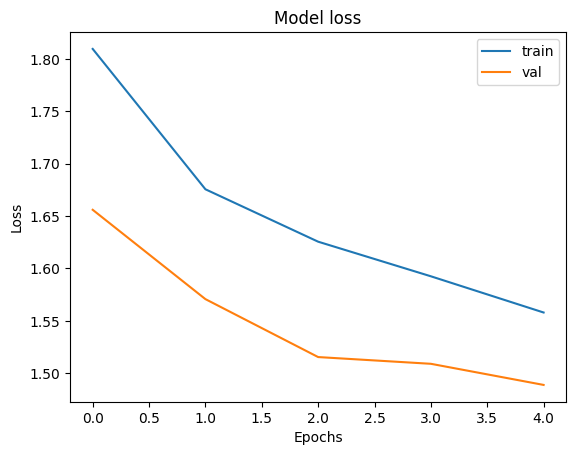

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

#### **MODEL EVALUATION**

In [ ]:
model.evaluate(val_data)

225/225 [==============================] - 9s 38ms/step - loss: 1.4889 - accuracy: 0.4273 - top_k_accuracy: 0.6159


[1.4888783693313599, 0.4272778034210205, 0.6159096956253052]

#### **TESTING**

In [ ]:
test_image = cv2.imread("C:/Datasets/fer2013/train/happy/Training_164916.jpg")
im = tf.constant(test_image, dtype = tf.float32)
print(im.shape)

(48, 48, 3)


In [ ]:
im = tf.expand_dims(im, axis = 0)

In [ ]:
CLASS_NAMES[tf.argmax(model(im), axis = -1).numpy()[0]]

'happy'

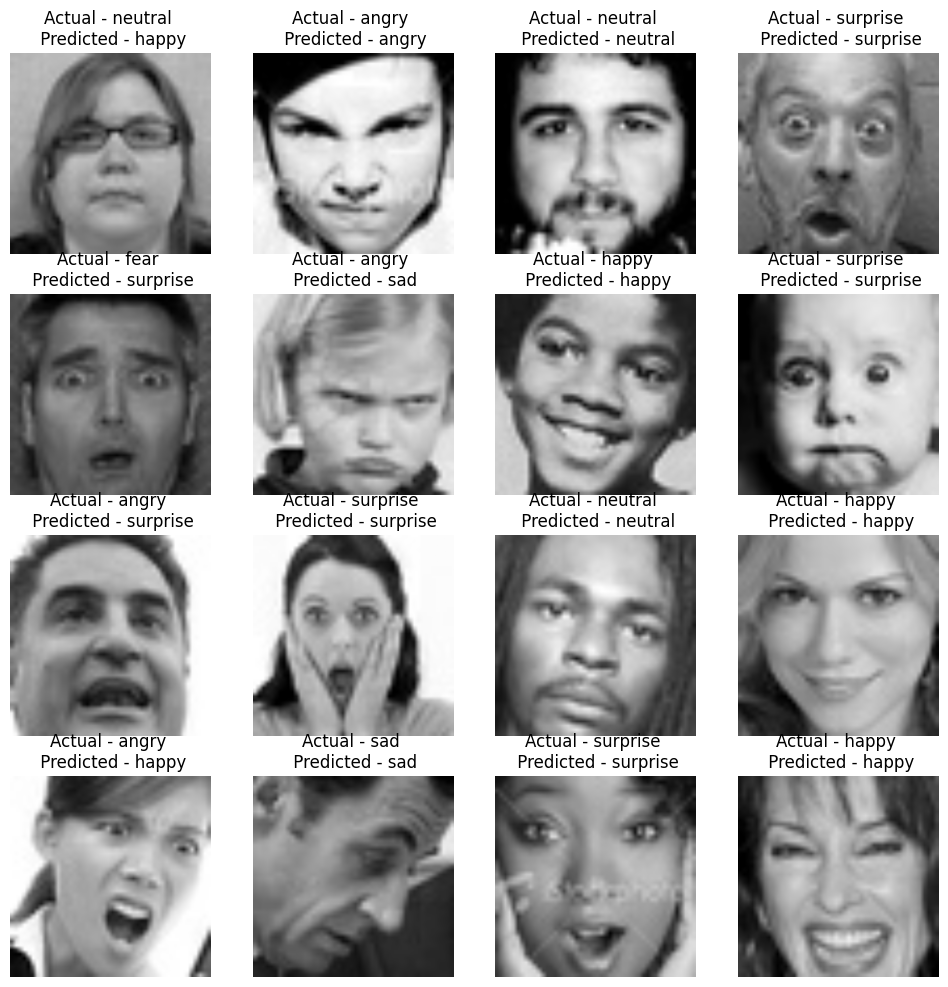

In [ ]:
plt.figure(figsize=(12,12))
for images, labels in val_data.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(f"Actual - {CLASS_NAMES[tf.argmax(labels[i],axis = 0).numpy()]} \n Predicted - {CLASS_NAMES[tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]}")
        plt.axis('off')

#### **CONFUSION MATRIX**

In [ ]:
labels = []
predicted = []
for image, label in val_data:
    labels.append(label.numpy())
    predicted.append(model(image))

In [ ]:
actual = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
predicted = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

In [ ]:
len(predicted)

7178

[[ 144    0   77  260  184  174  119]
 [  28    0   12   32   18   13    8]
 [  68    0  123  248  194  156  235]
 [  50    0   55 1329  132  121   87]
 [  62    0   55  310  520  167  119]
 [ 103    0   94  317  247  381  105]
 [  19    0   38  101   60   43  570]]


Text(0.5, 58.7222222222222, 'Predicted')

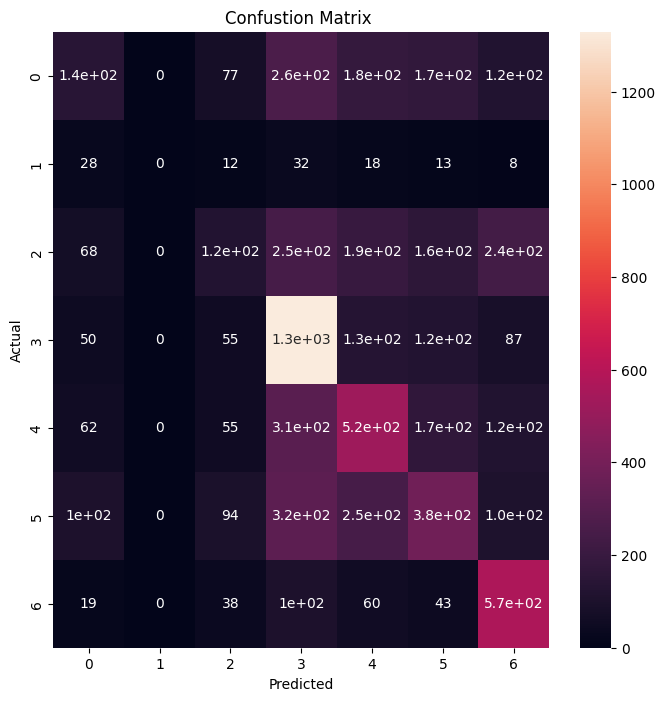

In [ ]:
cm = confusion_matrix(actual, predicted)
print(cm)

plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True)
plt.title("Confustion Matrix ")
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [ ]:
model.save('fer13_model.h5')

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
import os
os.chdir('../')
os.listdir('artifacts/data_preprocessing/train_tfrecords')

['shard_00.tfrecord',
 'shard_01.tfrecord',
 'shard_02.tfrecord',
 'shard_03.tfrecord',
 'shard_04.tfrecord',
 'shard_05.tfrecord',
 'shard_06.tfrecord',
 'shard_07.tfrecord',
 'shard_08.tfrecord',
 'shard_09.tfrecord']